In [88]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score, accuracy_score
from itertools import cycle
import matplotlib.pyplot as plt

In [92]:
def plot_precision_recall_curve(n_classes, precision, recall):
    # Taken from https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
    
    # setup plot details
    colors = cycle(['navy', 'turquoise', 'darkorange'])

    plt.figure(figsize=(7, 8))
    lines = []
    labels = []

    l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
    lines.append(l)
    labels.append('micro-average Precision-recall')

    for i, color in zip(range(n_classes), colors):
        l, = plt.plot(recall[i], precision[i], color=color, lw=2)
        lines.append(l)
        labels.append('Precision-recall for class {0}'.format(i))

    fig = plt.gcf()
    fig.subplots_adjust(bottom=0.25)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))

    plt.show()

def show_classification_metrics(classifier, features, y_true, n_classes):
    prob = None
    y_pred = classifier.predict(features)
    
    try:
        prob = classifier.predict_proba(features)
    except:
        pass
    
    if prob is None:
        try:
            prob = classifier.decision_function(features)
        except:
            print("Cannot get class probability or decision function from classifier")
            return
    

    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], prob[:, i])
        average_precision[i] = average_precision_score(y_true[:, i], prob[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_true.ravel(),prob.ravel())
    average_precision["micro"] = average_precision_score(y_true, prob,average="micro")
    print('Average precision score, micro-averaged over all classes: {0:0.2f}'.format(average_precision["micro"]))
    print()
    
    precision_micro = precision_score(y_true, y_pred, average="micro")
    precision_weighted = precision_score(y_true, y_pred, average="weighted")
    precision_macro = precision_score(y_true, y_pred, average="macro")

    recall_micro = recall_score(y_true, y_pred, average="micro")
    recall_weighted = recall_score(y_true, y_pred, average="weighted")
    recall_macro = recall_score(y_true, y_pred, average="macro")

    f1_micro = f1_score(y_true, y_pred, average="micro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")
    f1_macro = f1_score(y_true, y_pred, average="macro")

    print("Accuracy score: {:.3f}".format(accuracy_score(y_true, y_pred)))
    print()
    
    print("Precision score (micro): {:.3f}".format(precision_micro))
    print("Recall score (micro): {:.3f}".format(recall_micro))
    print("F1 score (micro): {:.3f}".format(f1_micro))
    print()
    print("Precision score (weighted): {:.3f}".format(precision_weighted))
    print("Recall score (weighted): {:.3f}".format(recall_weighted))
    print("F1 score (weighted): {:.3f}".format(f1_weighted))
    print()
    print("Precision score (macro): {:.3f}".format(precision_macro))
    print("Recall score (macro): {:.3f}".format(recall_macro))
    print("F1 score (macro): {:.3f}".format(f1_macro))
    
    plot_precision_recall_curve(n_classes, precision, recall)

In [7]:
train_df = pd.read_csv("Data/formated.csv")
test_df = pd.read_csv("Data/formatedTesting.csv")

In [10]:
train_df.columns = [col.strip() for col in df.columns]
test_df.columns = [col.strip() for col in test_df.columns]

There's some imbalance between the target features as seen by the charts below. The number of games where the result is draw is significantly less than the other types

Text(0.5,1,'Target feature distribution in training set')

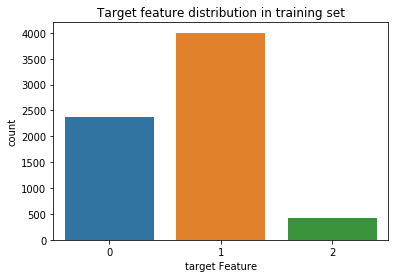

In [103]:
sns.countplot(train_df["target Feature"])
plt.title("Target feature distribution in training set")

Text(0.5,1,'Target feature distribution in test set')

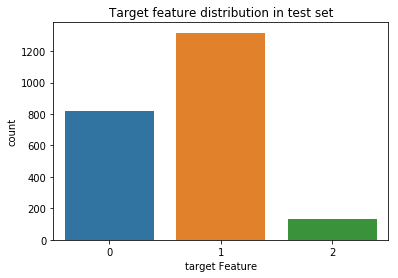

In [104]:
sns.countplot(test_df["target Feature"])
plt.title("Target feature distribution in test set")

In [65]:
train_features_array = train_df.iloc[:, :-1].values
train_labels_array = train_df.loc[:, "target Feature"].values
train_labels_binarized = label_binarize(train_labels_array, classes=[0,1,2])

test_features_array = test_df.iloc[:, :-1].values
test_labels_array = test_df.loc[:, "target Feature"].values
test_labels_binarized = label_binarize(test_labels_array, classes=[0,1,2])

In [66]:
# Normalize features to the range [0, 1]
normalizer = MinMaxScaler((0, 1))
train_features_normalized = normalizer.fit_transform(train_features_array)
test_features_normalized = normalizer.fit_transform(test_features_array)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [68]:
# Baseline SVM with RBF Kernel
rbf_baseline = OneVsRestClassifier(SVC())

rbf_baseline.fit(train_features_normalized, train_labels_binarized)

OneVsRestClassifier(estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          n_jobs=1)

Average precision score, micro-averaged over all classes: 0.79

Accuracy score: 0.680

Precision score (micro): 0.743
Recall score (micro): 0.680
F1 score (micro): 0.710

Precision score (weighted): 0.708
Recall score (weighted): 0.680
F1 score (weighted): 0.692

Precision score (macro): 0.487
Recall score (macro): 0.479
F1 score (macro): 0.482


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


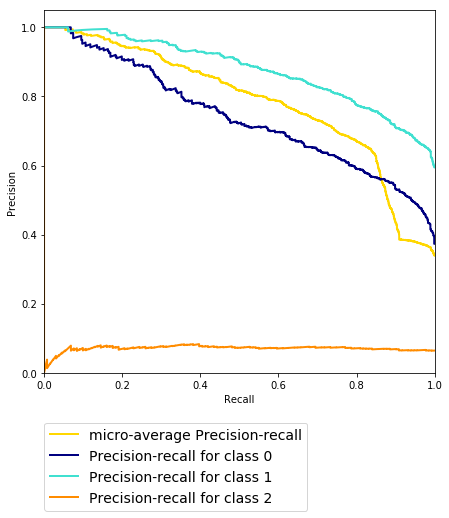

In [91]:
show_classification_metrics(rbf_baseline, test_features_normalized, test_labels_binarized, 3)